In [20]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [21]:
release=None

In [22]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-05,2021-02-04,United Kingdom,K02000001,NaN,NaN,NaN,783851.0
1,2021-02-05,2021-02-03,United Kingdom,K02000001,15450.0,NaN,541.0,801949.0
2,2021-02-05,2021-02-02,United Kingdom,K02000001,18863.0,NaN,684.0,606382.0
3,2021-02-05,2021-02-01,United Kingdom,K02000001,21622.0,2578.0,764.0,643204.0
4,2021-02-05,2021-01-31,United Kingdom,K02000001,15360.0,2377.0,752.0,574012.0
...,...,...,...,...,...,...,...,...
367,2021-02-05,2020-02-03,United Kingdom,K02000001,0.0,NaN,NaN,NaN
368,2021-02-05,2020-02-02,United Kingdom,K02000001,1.0,NaN,NaN,NaN
369,2021-02-05,2020-02-01,United Kingdom,K02000001,1.0,NaN,NaN,NaN
370,2021-02-05,2020-01-31,United Kingdom,K02000001,2.0,NaN,NaN,NaN


In [23]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-05.csv')

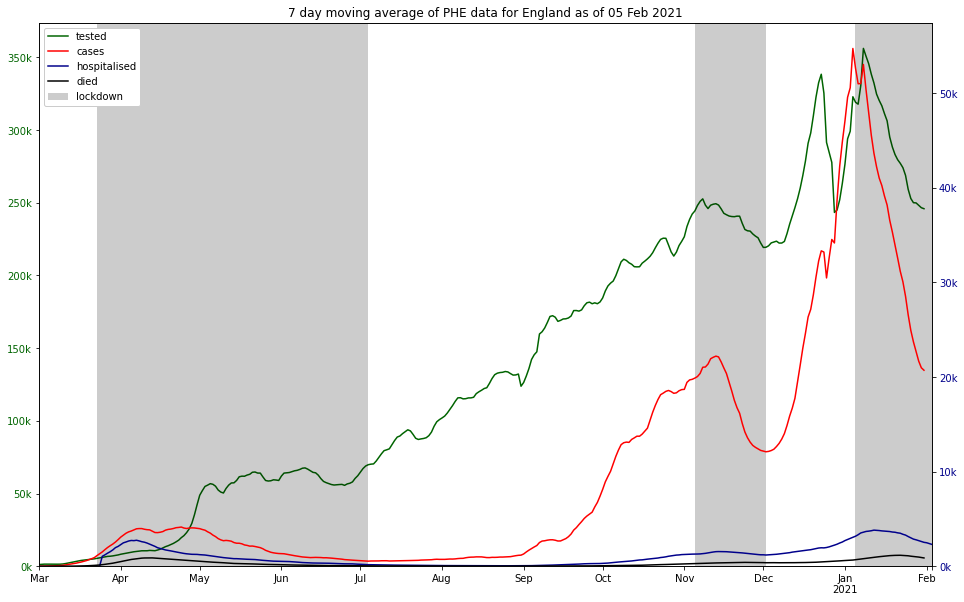

In [24]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [25]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-05.csv')

In [26]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-05.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,468782.0,9430261.0,8961479.0,56286961,0.832843,15.921057,83.246100
1,Northern Ireland,N92000002,26047.0,275232.0,249185.0,1893667,1.375479,13.158861,85.465660
2,Scotland,S92000003,9657.0,742512.0,732855.0,5463300,0.176761,13.414145,86.409093
3,Wales,W92000004,1635.0,523042.0,521407.0,3152879,0.051857,16.537488,83.410654


'partial: 10,971,047'

'full: 506,121'

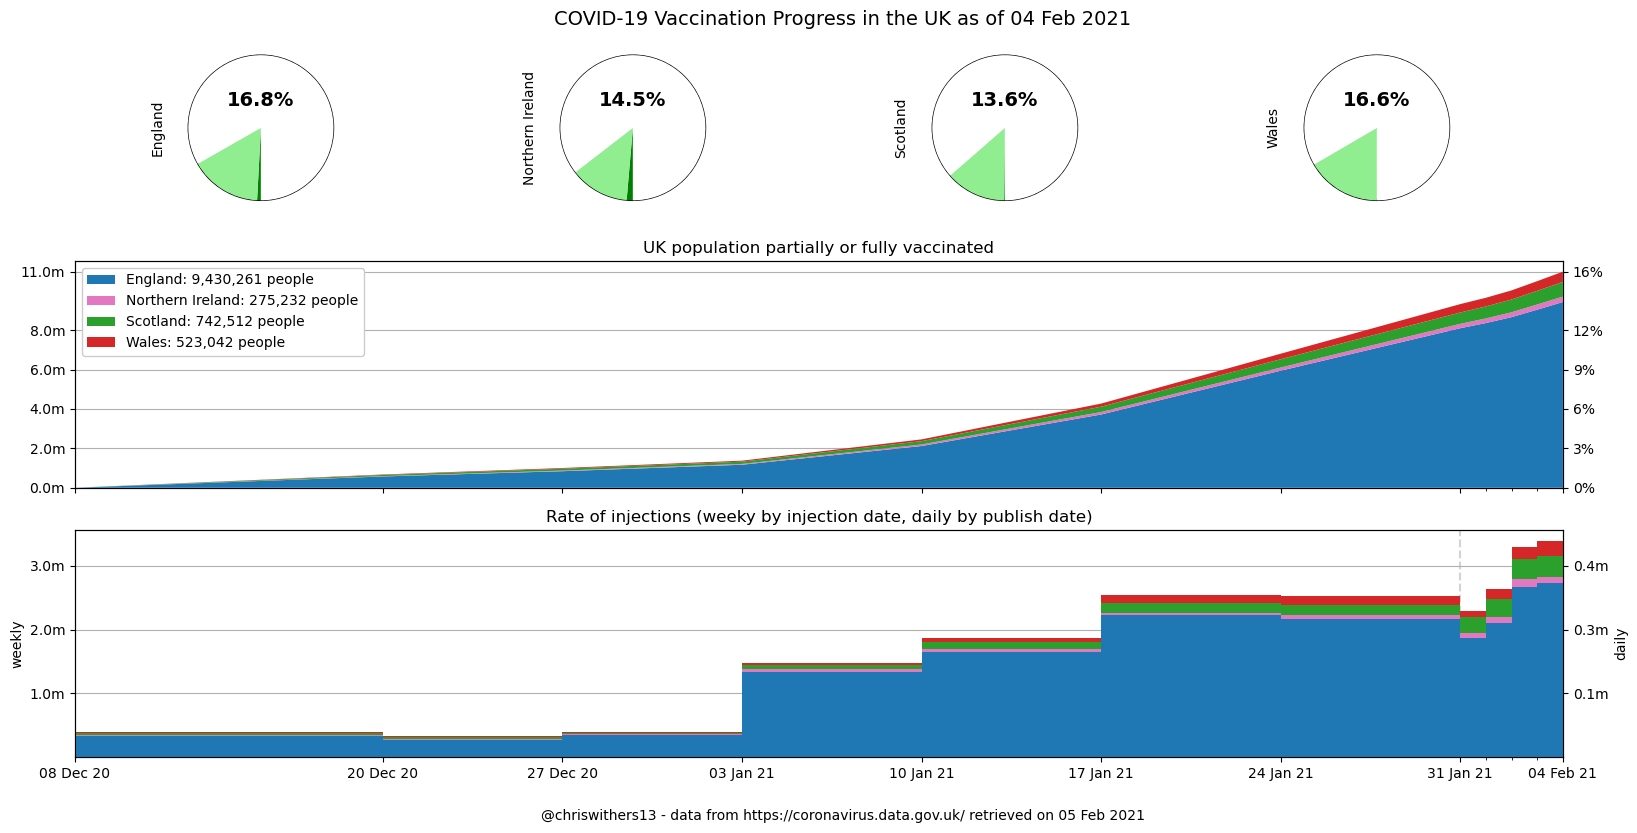

In [27]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [28]:
vaccination_changes()

,,First Dose (New),Second Dose (Total),Complete (New),First Dose (Total),cumPeopleVaccinatedSecondDoseByPublishDate,Complete (Total)
,,,,,,,
England,04 Feb 21,"+388,426","+2,611","+2,611","+9,430,261","+468,782","+468,782"
Northern Ireland,04 Feb 21,"+11,497",+508,+508,"+275,232","+26,047","+26,047"
Scotland,04 Feb 21,"+48,165",+498,+498,"+742,512","+9,529","+9,529"
Wales,04 Feb 21,"+32,472",+419,+419,"+523,042","+1,635","+1,635"


In [29]:
download(nation, nation, new_admissions, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-05.csv')

In [30]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-05.csv')

In [31]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-05.csv')